# <span style="color:STEELBLUE">**Set Up**</span>

### Import libraries and data

In [1]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.21.3.


In [2]:
import pandas as pd
from pandas.plotting import scatter_matrix

import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, ShuffleSplit, cross_validate
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
#from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, r2_score, classification_report
from sklearn.inspection import partial_dependence, plot_partial_dependence

import math

from collections import defaultdict

from rfpimp import *
#from rfpimp import plot_corr_heatmap

from pycebox.ice import *
from pdpbox import *

In [3]:
file = "/Users/lszczyrba/Documents/Research/Projects/PR_Housing/Data/master_df_20191203.xlsx"
data = pd.read_excel(file)
df_master = pd.DataFrame(data).set_index('FIPS')

In [4]:
print(df_master.columns)

Index(['PropSFHA', 'AveDepth', 'PropDG', 'MaxDepth', 'AveLS', 'HurTrack',
       'PeakGust', 'MaxSusta', 'SpecCom', 'STRVI_1', 'SEVI_1', 'STR_SEVI_1',
       'SOVI_1', 'STRVI_2', 'SEVI_2', 'SOVI_2', 'CDC_T1', 'CDC_T2', 'CDC_T3',
       'CDC_T4', 'CDC_Tot', 'O_IND', 'R_IND', 'R_I_NO0', 'R_I_NOO',
       'R_I_NO0_NO', 'CAT_3Q', 'CAT_4Q', 'Ex_Q4_c', 'COUNT__Y', 'R_DES',
       'R_AFF', 'log_R_IND', 'log_R_I_NO0'],
      dtype='object')


### Choose Data

In [5]:
def choose_data(df_master, feature_list, target_list):
    choices = feature_list + target_list
    df = df_master[choices].copy()
    df.dropna(inplace = True)
    return df

In [22]:
# EXAMPLE:
feature_list = ['PropSFHA', 'AveDepth', 'PropDG', 'AveLS', 'HurTrack',
               'PeakGust', 'SpecCom', 'STRVI_1', 'SEVI_1','CDC_Tot']
target_list = ['R_IND']

df = choose_data(df_master, feature_list, target_list)

In [23]:
df.describe()

,PropSFHA,AveDepth,PropDG,AveLS,HurTrack,PeakGust,SpecCom,STRVI_1,SEVI_1,CDC_Tot,R_IND
count,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000
mean,0.173662,0.982619,0.058447,1.104161,0.223594,52.697914,0.149686,0.000533,0.020068,0.500642,0.032037
std,0.260877,1.529905,0.159692,0.412690,0.126709,8.664104,0.374937,3.766862,5.450390,0.289171,0.035476
min,0.000000,0.000000,0.000000,0.000000,0.000000,24.590000,0.000000,-13.150000,-23.740000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,0.130000,45.150000,0.000000,-2.635000,-3.087500,0.250575,0.006897
50%,0.040000,0.000000,0.000000,1.000000,0.220000,55.880000,0.020777,-0.190000,0.630000,0.501150,0.022014
75%,0.220000,1.760000,0.020000,1.290000,0.290000,59.900000,0.103839,2.417500,3.697500,0.750525,0.044725
max,1.000000,9.730000,1.000000,3.000000,0.920000,65.710000,3.729129,16.520000,15.220000,1.000000,0.360825


In [12]:
# ### DELETE
# df = df[df.O_Ind != 0]

# <span style="color:STEELBLUE">**Explore Features**</span>


In [6]:
def histogram_figure(df_target): 
    from matplotlib import rcParams
    rcParams['axes.titlepad'] = 15
    fig, ax = plt.subplots(1,1,figsize=(6, 4))
    plt.rcParams["patch.force_edgecolor"] = True
    sns.distplot(df_target.values,kde=False)
    fig.text(0.5, 0.02, 'Proportion of Damaged Homes', ha='center', va = 'top', fontsize = 18)
    ax.set_title('Damage Index ', fontsize = 25)
    ax.tick_params(axis='both', which='major', labelsize=15)
#    plt.savefig('targethist_n0.png', dpi=600, bbox_inches = "tight")


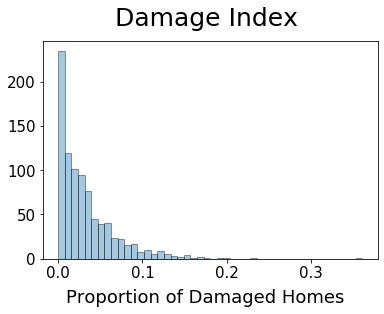

In [14]:
#EXAMPLE:
df_target = df['R_IND']
histogram_figure(df_target)

In [7]:
def boxplot_figure(df, target):
    fig, ax = plt.subplots(1,1,figsize=(4, 6))
    ax = df.boxplot(column=target, showfliers=True)
    ax.set_ylabel("Proportion of Damaged Homes", fontsize = 18)
    ax.tick_params(labelsize=15)
    #plt.savefig('boxplot_no0.png', dpi=600, bbox_inches = "tight")


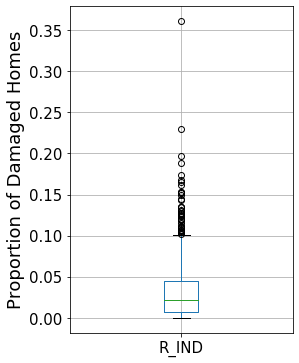

In [16]:
#EXAMPLE:
target = ['R_IND']
boxplot_figure(df, target)

Spearman

In statistics, Spearman's rank correlation coefficient or Spearman's rho, named after Charles Spearman and often denoted by the Greek letter (rho), is a nonparametric measure of rank correlation (statistical dependence between the rankings of two variables). It assesses how well the relationship between two variables can be described using a monotonic function.

The Spearman correlation between two variables is equal to the Pearson correlation between the rank values of those two variables; while Pearson's correlation assesses linear relationships, Spearman's correlation assesses monotonic relationships (whether linear or not). If there are no repeated data values, a perfect Spearman correlation of +1 or −1 occurs when each of the variables is a perfect monotone function of the other.

Text(2, 0.001, 'Spearman Correlation Matrix')

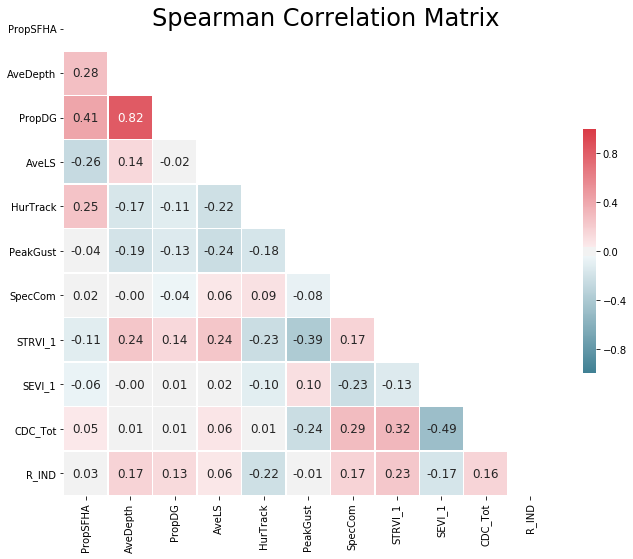

In [17]:
corr = df.corr(method='spearman')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask,annot=True, fmt='.2f',
                annot_kws={'size':12}, cmap=cmap, vmin=-1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.text(2, .001, 'Spearman Correlation Matrix', ha='left', va = 'top', fontsize = 24)

In [8]:
def spearman_matrix(df):
    plt.figure(figsize = (25,25))
    plt.rcParams['font.size'] = 20
    hm = sns.heatmap(df.corr(method = 'spearman'),
                cbar=True,
                annot=True,
                square=True,
                fmt='.2f',
                annot_kws={'size':15})
    



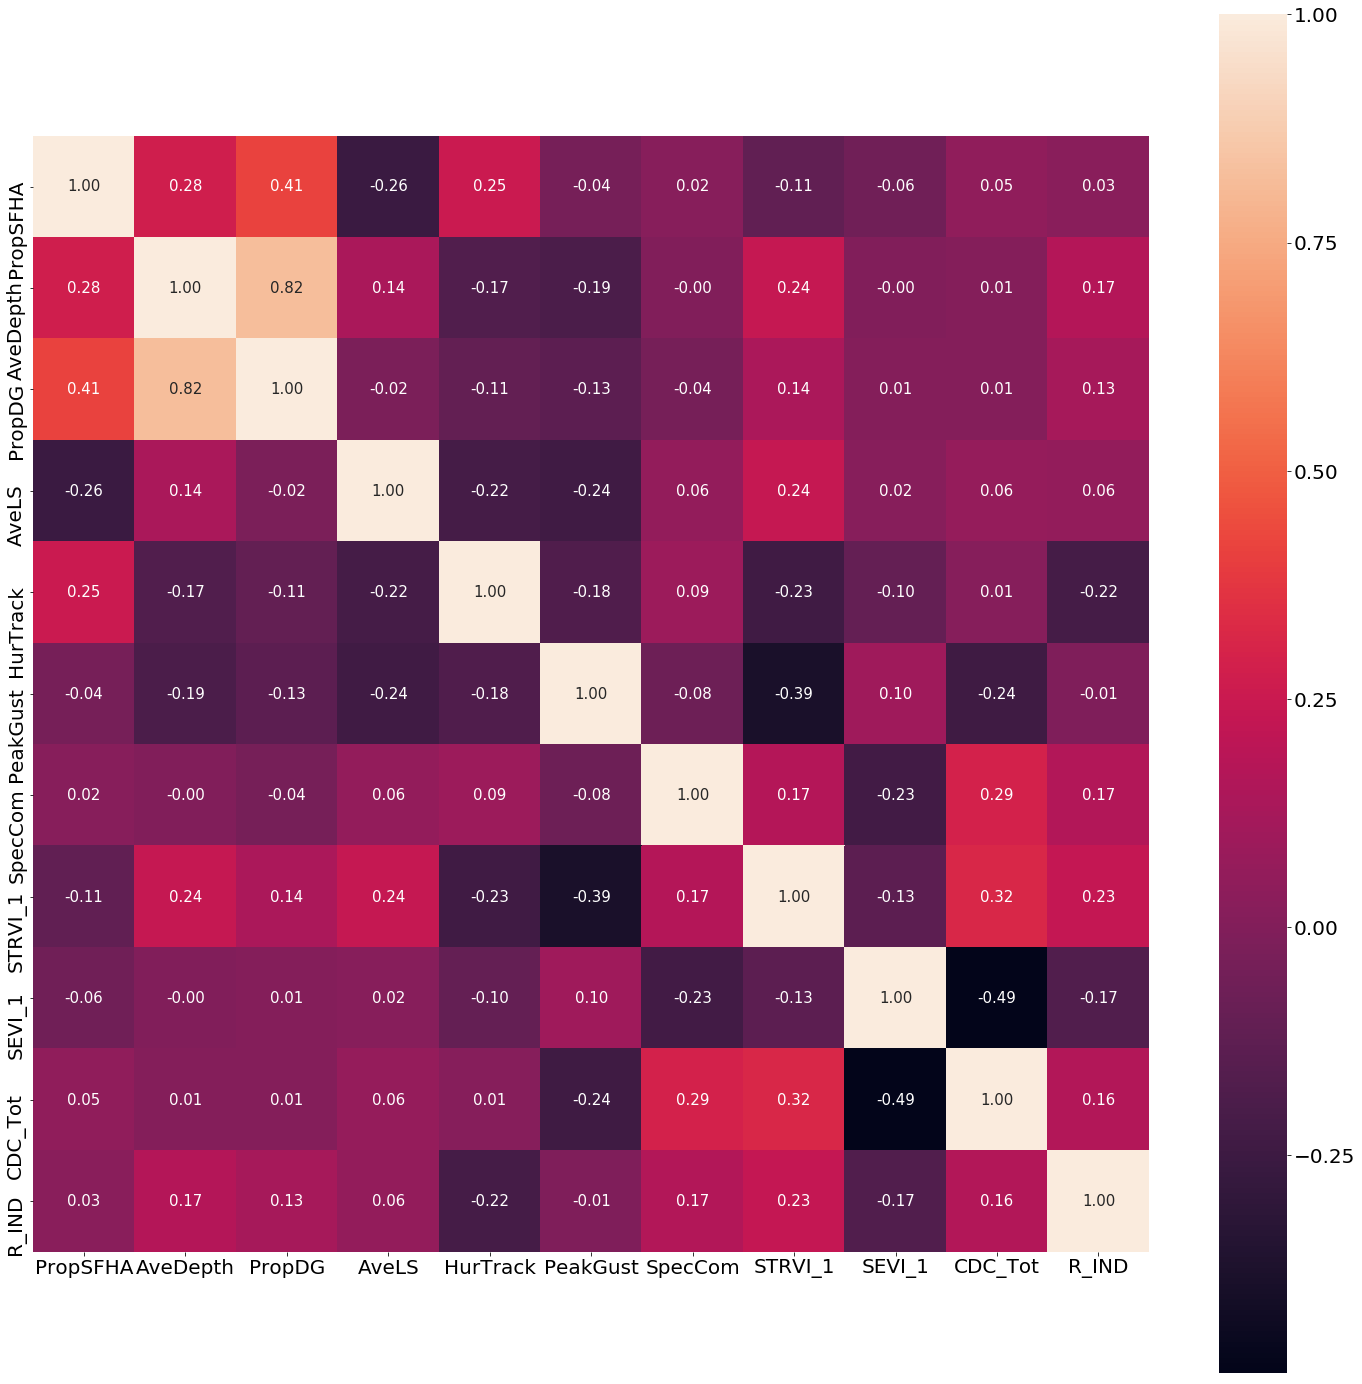

In [362]:
#EXAMPLE:
spearman_matrix(df)

In [9]:
def feature_matrix(df, target):
    fig = scatter_matrix(df, c=target, figsize = [15,15])
    for ax in fig.ravel():
        ax.set_xlabel(ax.get_xlabel(), fontsize = 14, rotation = 45)
        ax.set_ylabel(ax.get_ylabel(), fontsize = 14, rotation = 45, ha='right')


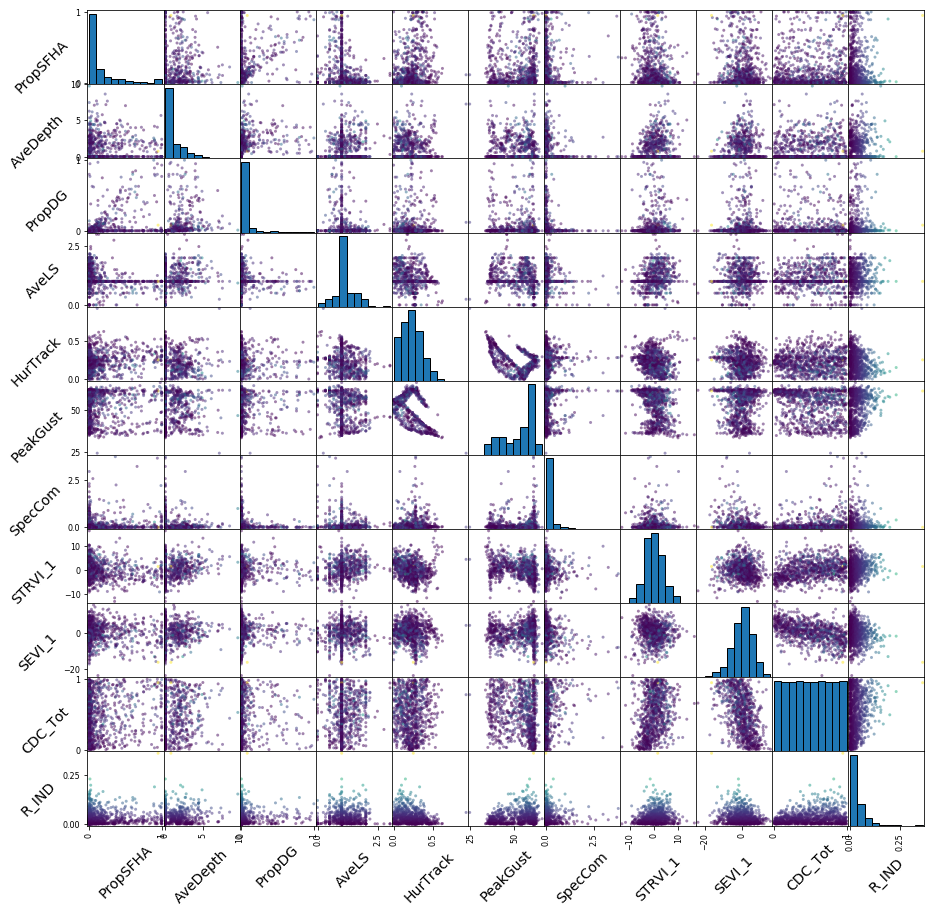

In [364]:
#EXAMPLE:
target = df['R_IND']
feature_matrix(df, target)

### Partition and Bin Data

In [8]:
def partition_data(df, target_str):
    y = df[target_str]
    df_x = df.drop(target_str, axis = 1)
    return y, df_x

In [20]:
# EXAMPLE:
target_str = 'R_IND'
y, df_x = partition_data(df, target_str)

In [9]:
def bin_target(y, n_bins, label):
    y_binned = pd.qcut(y, q=n_bins, labels = label)
    return y_binned

In [22]:
# EXAMPLE:
y_binned = bin_target(y,4, [0,1,2,3])

### Train, Test, Split

## Retest starting here

In [10]:
def split_the_data(df_x, y):
    x_train, x_test, y_train, y_test = train_test_split(df_x, y, 
                                                        test_size=0.3, 
                                                        random_state=42,
                                                        stratify = y_binned)
    return x_train, x_test, y_train, y_test


In [62]:
# Careful of Random State
# Change y_binned to y if categorical
# EXAMPLE:
x_train, x_test, y_train, y_test = split_the_data(df_x, y)

In [38]:
# train_set = x_train.copy()
# test_set = x_test.copy()

# train_set['y_train'] = y_train
# #train_set['train_pred'] = pred_train

# test_set['y_test'] = y_test
# #test_set['test_pred'] = pred_test

# train_set.to_excel("/Users/lszczyrba/Documents/Research/Projects/PR_Housing/Data/train_set_20191209.xlsx")
# test_set.to_excel("/Users/lszczyrba/Documents/Research/Projects/PR_Housing/Data/test_set_20191209.xlsx")

In [25]:
#histogram_figure(y_test)

# import pre-split train and test data

In [11]:
file = "/Users/lszczyrba/Documents/Research/Projects/PR_Housing/Data/train_set_20191209.xlsx"
data = pd.read_excel(file)
train_set = pd.DataFrame(data).set_index('FIPS')

In [12]:
file = "/Users/lszczyrba/Documents/Research/Projects/PR_Housing/Data/test_set_20191209.xlsx"
data = pd.read_excel(file)
test_set = pd.DataFrame(data).set_index('FIPS')

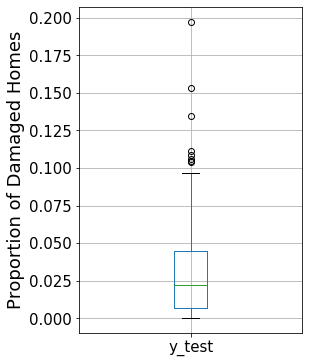

In [13]:
target = ['y_test']
boxplot_figure(test_set, target)

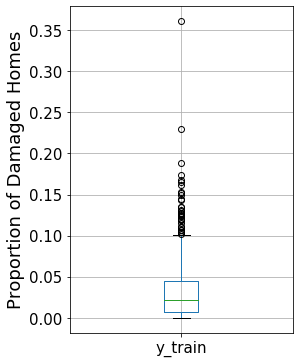

In [14]:
target = ['y_train']
boxplot_figure(train_set, target)

In [15]:
train_set.describe()

,PropSFHA,AveDepth,PropDG,AveLS,HurTrack,PeakGust,SpecCom,STRVI_1,SEVI_1,CDC_Tot,y_train
count,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000
mean,0.182426,0.960227,0.054596,1.087220,0.220227,52.920610,0.155422,0.005574,0.095021,0.505210,0.032379
std,0.268670,1.541750,0.151071,0.405675,0.126887,8.649156,0.393080,3.819139,5.505768,0.288732,0.036311
min,0.000000,0.000000,0.000000,0.000000,0.000000,24.590000,0.000000,-13.150000,-23.740000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,0.130000,45.600000,0.000000,-2.660000,-2.890000,0.260500,0.006873
50%,0.050000,0.000000,0.000000,1.000000,0.220000,56.330000,0.022076,-0.150000,0.710000,0.502800,0.021994
75%,0.250000,1.700000,0.020000,1.250000,0.290000,60.350000,0.105366,2.430000,3.830000,0.758800,0.044662
max,1.000000,9.730000,1.000000,3.000000,0.920000,65.710000,3.729129,16.520000,14.060000,1.000000,0.360825


# If want to drop the extreme outlier

In [16]:
# Get names of indexes for which column Age has value 30
indexNames = train_set[train_set.y_train > 0.25].index
 
# Delete these row indexes from dataFrame
train_set.drop(indexNames , inplace=True)

In [17]:
#train_set = train_set[train_set.y_train < 0.360825]

In [18]:
train_set.describe()

,PropSFHA,AveDepth,PropDG,AveLS,HurTrack,PeakGust,SpecCom,STRVI_1,SEVI_1,CDC_Tot,y_train
count,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000
mean,0.181335,0.960526,0.054560,1.087344,0.220185,52.909418,0.155643,0.003409,0.118509,0.504580,0.031913
std,0.267295,1.542826,0.151175,0.405950,0.126972,8.650195,0.393315,3.821421,5.474224,0.288451,0.034157
min,0.000000,0.000000,0.000000,0.000000,0.000000,24.590000,0.000000,-13.150000,-23.740000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,0.130000,45.600000,0.000000,-2.665000,-2.875000,0.260200,0.006865
50%,0.045000,0.000000,0.000000,1.000000,0.220000,56.330000,0.022166,-0.150000,0.710000,0.502250,0.021963
75%,0.242500,1.700000,0.020000,1.250000,0.290000,60.350000,0.105531,2.430000,3.832500,0.757075,0.044422
max,1.000000,9.730000,1.000000,3.000000,0.920000,65.710000,3.729129,16.520000,14.060000,1.000000,0.229145


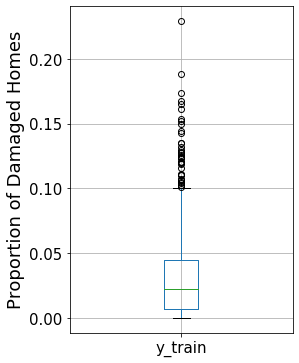

In [19]:
target = ['y_train']
boxplot_figure(train_set, target)

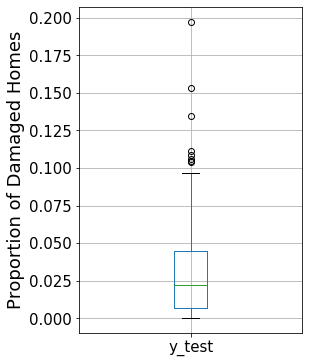

In [20]:
target = ['y_test']
boxplot_figure(test_set, target)

# If want to join to grab another Index

In [29]:
test_set = test_set.merge(df_master, right_index=True, left_index=True, how='left')

In [30]:
train_set=train_set.merge(df_master, right_index=True, left_index=True, how='left')

In [31]:
test_set.columns

Index(['PropSFHA_x', 'AveDepth_x', 'PropDG_x', 'AveLS_x', 'HurTrack_x',
       'PeakGust_x', 'SpecCom_x', 'STRVI_1_x', 'SEVI_1_x', 'CDC_Tot_x',
       'y_test', 'PropSFHA_y', 'AveDepth_y', 'PropDG_y', 'MaxDepth', 'AveLS_y',
       'HurTrack_y', 'PeakGust_y', 'MaxSusta', 'SpecCom_y', 'STRVI_1_y',
       'SEVI_1_y', 'STR_SEVI_1', 'SOVI_1', 'STRVI_2', 'SEVI_2', 'SOVI_2',
       'CDC_T1', 'CDC_T2', 'CDC_T3', 'CDC_T4', 'CDC_Tot_y', 'O_IND', 'R_IND',
       'R_I_NO0', 'R_I_NOO', 'R_I_NO0_NO', 'CAT_3Q', 'CAT_4Q', 'Ex_Q4_c',
       'COUNT__Y', 'R_DES', 'R_AFF', 'log_R_IND', 'log_R_I_NO0'],
      dtype='object')

In [32]:
train_set.columns

Index(['PropSFHA_x', 'AveDepth_x', 'PropDG_x', 'AveLS_x', 'HurTrack_x',
       'PeakGust_x', 'SpecCom_x', 'STRVI_1_x', 'SEVI_1_x', 'CDC_Tot_x',
       'y_train', 'PropSFHA_y', 'AveDepth_y', 'PropDG_y', 'MaxDepth',
       'AveLS_y', 'HurTrack_y', 'PeakGust_y', 'MaxSusta', 'SpecCom_y',
       'STRVI_1_y', 'SEVI_1_y', 'STR_SEVI_1', 'SOVI_1', 'STRVI_2', 'SEVI_2',
       'SOVI_2', 'CDC_T1', 'CDC_T2', 'CDC_T3', 'CDC_T4', 'CDC_Tot_y', 'O_IND',
       'R_IND', 'R_I_NO0', 'R_I_NOO', 'R_I_NO0_NO', 'CAT_3Q', 'CAT_4Q',
       'Ex_Q4_c', 'COUNT__Y', 'R_DES', 'R_AFF', 'log_R_IND', 'log_R_I_NO0'],
      dtype='object')

In [33]:
# EXAMPLE:
feature_list = ['PropSFHA_y', 'AveDepth_y', 'PropDG_y', 'AveLS_y', 'HurTrack_y',
               'PeakGust_y', 'SpecCom_y', 'STRVI_1_y', 'SEVI_1_y','CDC_Tot_y']
target_list = ['log_R_I_NO0']

test_set = choose_data(test_set, feature_list, target_list)

In [34]:
# EXAMPLE:
feature_list = ['PropSFHA_y', 'AveDepth_y', 'PropDG_y', 'AveLS_y', 'HurTrack_y',
               'PeakGust_y', 'SpecCom_y', 'STRVI_1_y', 'SEVI_1_y','CDC_Tot_y']
target_list = ['log_R_I_NO0']

train_set = choose_data(train_set, feature_list, target_list)

In [35]:
train_set.columns

Index(['PropSFHA_y', 'AveDepth_y', 'PropDG_y', 'AveLS_y', 'HurTrack_y',
       'PeakGust_y', 'SpecCom_y', 'STRVI_1_y', 'SEVI_1_y', 'CDC_Tot_y',
       'log_R_I_NO0'],
      dtype='object')

In [36]:
train_set = train_set.rename(columns={"PropSFHA_y": "PropSFHA", "AveDepth_y": "AveDepth", "PropDG_y":"PropDG",
                        "AveLS_y": "AveLS", "HurTrack_y": "HurTrack", "PeakGust_y":"PeakGust",
                        "SpecCom_y": "SpecCom", "STRVI_1_y": "STRVI_1", "SEVI_1_y":"SEVI_1",
                        "CDC_Tot_y": "CDC_Tot", "log_R_I_NO0":"log_R_I_NO0"})

In [37]:
test_set = test_set.rename(columns={"PropSFHA_y": "PropSFHA", "AveDepth_y": "AveDepth", "PropDG_y":"PropDG",
                        "AveLS_y": "AveLS", "HurTrack_y": "HurTrack", "PeakGust_y":"PeakGust",
                        "SpecCom_y": "SpecCom", "STRVI_1_y": "STRVI_1", "SEVI_1_y":"SEVI_1",
                        "CDC_Tot_y": "CDC_Tot", "log_R_I_NO0":"log_R_I_NO0"})

# Partition Data

In [21]:
target_str = 'y_train'
y_train, x_train = partition_data(train_set, target_str)

target_str = 'y_test'
y_test, x_test = partition_data(test_set, target_str)

### Step 1: Randomized Search CV

In [27]:
def randomized_cv(x_train, y_train, model):
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]

    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf}
    
    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    rf = model
    # Random search of parameters, using cv = cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_randomized_cv = RandomizedSearchCV(estimator = rf, 
                                          param_distributions = random_grid, 
                                          n_iter = 100, 
                                          cv = 5, 
                                          verbose=2, 
                                          random_state=42, 
                                          n_jobs = -1)
    
    # Fit the random search model
    rf_randomized_cv.fit(x_train, y_train)
    
    print(rf_randomized_cv.best_params_)
    return rf_randomized_cv.best_estimator_
    

In [28]:
#EXAMPLE
#Random state
#CHOOSE IF REGRESSOR OR CLASSIFICATION
random_tuned_model = randomized_cv(x_train, y_train, RandomForestRegressor())

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.6min finished


{'n_estimators': 2000, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 70}


In [20]:
random_tuned_model.get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1577,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)>

### Step 2: Grid Search CV

In [42]:
def grid_cv(x_train, y_train, model):
    param_grid = {
        'max_depth': [50, 75, 100, 125, 250],
        'max_features': [2, 3, 4],
        'min_samples_leaf': [1, 2, 3, 4],
        'min_samples_split': [2, 3, 4, 5],
        'n_estimators': [1000, 1250, 1500]
    }
    # Create a based model
    rf = model
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator = rf, 
                               param_grid = param_grid, 
                               cv = 5, n_jobs = -1, 
                               verbose = 2)
    grid_search.fit(x_train, y_train)
    
    print(grid_search.best_params_)
    print(grid_search.best_score_)
    return grid_search.best_estimator_

In [43]:
#Example
#CHOOSE IF REGRESSOR OR CLASSIFICATION
tuned_model = grid_cv(x_train, y_train, RandomForestRegressor())

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed: 19.6min finished
/Users/lszczyrba/Library/Python/3.6/lib/python/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are 

{'max_depth': 250, 'max_features': 2, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1000}
0.187827742648


In [44]:
tuned_model.get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=250,
                      max_features=2, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)>

## Intensive CV

This uses out of bag data for assessment, maybe can run on entire dataset???

In [66]:
def intens_grid_cv(x_train, y_train, model):
    param_grid = {
        'max_depth': [10,15,20,25,30,40,50,75,100],
        'max_features': [1,2,3,4],
        'min_samples_leaf': [1,2,3],
        'min_samples_split': [2,3,4,5,6],
        'n_estimators': [500,1000,1250,1500,1750,2000]
    }
    # Create a based model
    rf = model
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator = rf, 
                               param_grid = param_grid, 
                               cv = 5, n_jobs = -1, 
                               verbose = 2)
    grid_search.fit(x_train, y_train)
    
    print(grid_search.best_estimator_)
    print(grid_search.best_score_)
    return grid_search.best_estimator_, grid_search.best_score_

In [67]:
#Example
#CHOOSE IF REGRESSOR OR CLASSIFICATION
tuned_model,score = intens_grid_cv(x_train, y_train, RandomForestRegressor())
tuned_model.score

Fitting 5 folds for each of 3240 candidates, totalling 16200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 23.0min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 28.9min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 35.0min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 41.7min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 48.6min
[Parallel(n_jobs=-1)]: Done 9097 tasks      | e

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
                      max_features=1, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
0.122799128782


<bound method RegressorMixin.score of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
                      max_features=1, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)>

# Save Optimization

Notes --  \
Version: R_Ind , Score: 0.61, 0.21

In [22]:
tune_reg_1 = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
           max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=4,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
OPT1 = tune_reg_1.fit(x_train, y_train)
print(OPT1.score(x_test, y_test))
print(OPT1.score(x_train, y_train))

0.261305971719
0.589100732033


Notes --  \
Version: R_Ind , Score: 0.90, 0.22

In [23]:
tune_reg_2 = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=17,
                      max_features=1, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
OPT2=tune_reg_2.fit(x_train, y_train)
print(OPT2.score(x_test, y_test))
print(OPT2.score(x_train, y_train))

0.282447955411
0.887339380957


Notes --  \
Version: R_Ind , Score: 0.88, 0.22

In [24]:
tune_reg_3=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1500, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
OPT3=tune_reg_3.fit(x_train, y_train)
print(OPT3.score(x_test, y_test))
print(OPT3.score(x_train, y_train))

0.296560728137
0.886675948045


Notes --  \
Version: log_R_I_NO0, Score: 0.85, 0.23

In [25]:
tune_reg_4 = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features=2, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=1750,
                      n_jobs=None, oob_score=False, random_state=42,
                      verbose=0, warm_start=False)
OPT4=tune_reg_4.fit(x_train, y_train)
print(OPT4.score(x_test, y_test))
print(OPT4.score(x_train, y_train))

0.288733954221
0.836631384058


Using R_IND and tuning based on entire dataset

In [26]:
tune_reg_5 = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
                      max_features=1, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
OPT5=tune_reg_5.fit(x_train, y_train)
print(OPT5.score(x_test, y_test))
print(OPT5.score(x_train, y_train))

0.262259813901
0.70073158745


Using R_IND_No0 and ideal train/test sets

In [27]:
tune_reg_6 = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=250,
                      max_features=2, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
OPT6=tune_reg_6.fit(x_train, y_train)
print(OPT6.score(x_test, y_test))
print(OPT6.score(x_train, y_train))

0.28588069089
0.763751649246


# <span style="color:STEELBLUE">**Run Models**</span>

### Tuned Model

In [23]:
def run_tuned_model(x_train,y_train):
    tuned_model.fit(x_train, y_train)
    return tuned_model

In [24]:
hypertune_model = run_tuned_model(x_train, y_train)

----------------

### Standard Regression Model

In [15]:
def run_regression(x_train, y_train):
    reg_model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
           max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=4,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False) 
    reg_model.fit(x_train, y_train)
    return reg_model

In [16]:
# EXAMPLE
# Careful of Random State
reg_model = run_regression(x_train, y_train)

----------------

# <span style="color:STEELBLUE">**Evaluate Models**</span>

### Make Predictions

In [28]:
def prediction(model, x_train, x_test):
    pred_train = model.predict(x_train)
    pred_test = model.predict(x_test)   
    return pred_train, pred_test

In [29]:
# EXAMPLE
#CHOOSE MODEL
pred_train, pred_test = prediction(OPT3, x_train, x_test)

### Evaluate Regression

In [30]:
def evaluate_regression(pred_train, pred_test, y_train, y_test):
    r_train = r2_score(y_train, pred_train)
    print('The training r-squared score is {}'.format(r_train))
    r_test = r2_score(y_test, pred_test)
    print('The testing r-squared score is {}'.format(r_test))
    meanabserrors_train = np.mean(abs(pred_train - y_train))
    print('The training mean absolute error is {}'.format(meanabserrors_train))
    meanabserrors_test = np.mean(abs(pred_test - y_test))
    print('The testing mean absolute error is {}'.format(meanabserrors_test))
    rmse = math.sqrt(mean_squared_error(y_test, pred_test))
    print('The root mean square error is {}'.format(rmse))
    mse = mean_squared_error(y_test, pred_test)
    print('The mean square error is {}'.format(mse))
    errors = pred_test - y_test
    meanerror = np.mean(errors)
    print('The mean error is {}'.format(meanerror))
    return errors

In [31]:
# EXAMPLE
errors = evaluate_regression(pred_train, pred_test, y_train, y_test)

The training r-squared score is 0.8866759480454934
The testing r-squared score is 0.2965607281373749
The training mean absolute error is 0.008210541338503475
The testing mean absolute error is 0.019692548366774105
The root mean square error is 0.026758362787255515
The mean square error is 0.0007160099790543807
The mean error is 0.0019885933470831043


In [32]:
def analyze_errors(errors):
    error_range =  max(errors) - min(errors)
    print('The error range is {}'.format(error_range))
    error_max = max(errors)
    print('The error max is {}'.format(error_max))
    error_min = min(errors)
    print('The error min is {}'.format(error_min))
    

In [33]:
# EXAMPLE
analyze_errors(errors)

The error range is 0.19050659510679074
The error max is 0.04612340227643969
The error min is -0.14438319283035106


In [34]:
def plot_errors(errors):
    plt.hist(errors, 30, histtype='bar', ec='white', color='maroon')
    plt.xlabel('Error')
    plt.ylabel('Count')
    plt.title('Histogram of Model Error')
    plt.grid(True)
    plt.show()


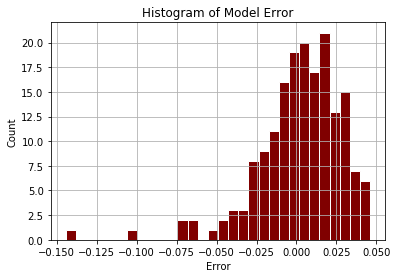

In [35]:
# EXAMPLE
plot_errors(errors)

In [38]:
def plot_predictions(y_test, pred, Title):
    df_predictions = pd.DataFrame(y_test)
    df_predictions['Pred'] = pred
    X = df_predictions.iloc[:, 0].values.reshape(-1, 1)
    Y = df_predictions.iloc[:, 1].values.reshape(-1, 1)
    fig, ax = plt.subplots()
    ax.scatter(X, Y, color='maroon')
    line = mlines.Line2D([0, 1], [0, 1], color='orange')
    transform = ax.transAxes
    line.set_transform(transform)
    ax.add_line(line)
    ax.set_xlabel(ax.get_xlabel(), fontsize = 18)
    ax.set_ylabel(ax.get_ylabel(), fontsize = 18)
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.grid(True)
    plt.xlabel("Damage Index")
    plt.ylabel("Precited Damage Index")
    plt.xlim(0,0.25)
    plt.ylim(0,0.25)
    plt.title('Model Evaluation -' +  Title, fontsize = 20)
    #plt.savefig('test_eval.png', dpi=600, bbox_inches = "tight")
    plt.show()

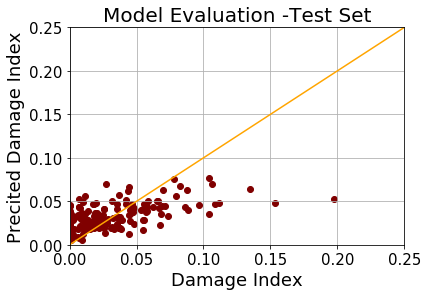

In [39]:
# EXAMPLE
Title = 'Test Set'
plot_predictions(y_test, pred_test, Title)

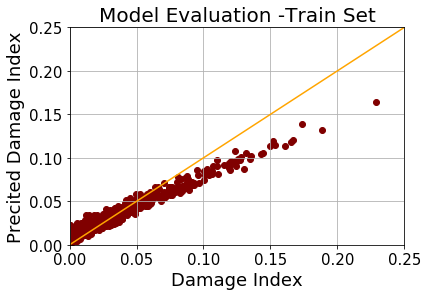

In [40]:
Title = 'Train Set'
plot_predictions(y_train, pred_train, Title)

In [41]:
def plot_joint_predictions(y_train, pred_train, y_test, pred_test, Title):
    df_predictions_test = pd.DataFrame(y_test)
    df_predictions_test['Pred'] = pred_test
    df_predictions_train = pd.DataFrame(y_train)
    df_predictions_train['Pred'] = pred_train   
    X1 = df_predictions_test.iloc[:, 0].values.reshape(-1, 1)
    Y1 = df_predictions_test.iloc[:, 1].values.reshape(-1, 1)
    X2 = df_predictions_train.iloc[:, 0].values.reshape(-1, 1)
    Y2 = df_predictions_train.iloc[:, 1].values.reshape(-1, 1)
    
    fig, ax = plt.subplots()
    ax.scatter(X2, Y2, color='maroon', label='Training Predictions')
    ax.scatter(X1, Y1, color='orange', label='Testing Predictions')
    
    line = mlines.Line2D([0, 1], [0, 1], color='grey')
    transform = ax.transAxes
    line.set_transform(transform)
    ax.add_line(line)
    ax.set_xlabel(ax.get_xlabel(), fontsize = 18)
    ax.set_ylabel(ax.get_ylabel(), fontsize = 18)
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.grid(True)
    plt.xlabel("Damage Index")
    plt.ylabel("Precited Damage Index")
    plt.xlim(0,0.25)
    plt.ylim(0,0.25)
    plt.title('Model Evaluation -' +  Title, fontsize = 20)
    plt.legend(loc='upper left')
    #plt.savefig('test_eval.png', dpi=600, bbox_inches = "tight")
    plt.show()

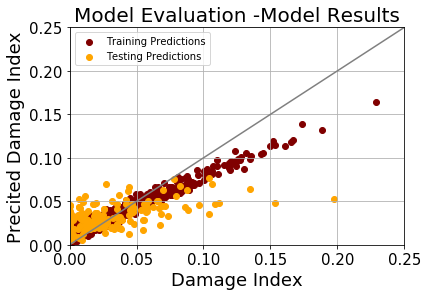

In [42]:
Title = 'Model Results'
plot_joint_predictions(y_train, pred_train, y_test, pred_test, Title)

-----------

# <span style="color:STEELBLUE">**Analyze Results**</span>

In [43]:
x_train.columns

Index(['PropSFHA', 'AveDepth', 'PropDG', 'AveLS', 'HurTrack', 'PeakGust',
       'SpecCom', 'STRVI_1', 'SEVI_1', 'CDC_Tot'],
      dtype='object')

## Gini Importance Calculation

Tree based models provides a different measure of feature importances based on the mean decrease in impurity (MDI, the splitting criterion - The function to measure the quality of a split. Supported criteria are “mse” for the mean squared error, which is equal to variance reduction as feature selection criterion, and “mae” for the mean absolute error). This gives importance to features that may not be predictive on unseen data. The permutation feature importance avoids this issue, since it can be applied to unseen data. Furthermore, impurity-based feature importance for trees are strongly biased and favor high cardinality features (typically numerical features). Permutation-based feature importances do not exhibit such a bias. Additionally, the permutation feature importance may use an arbitrary metric on the tree’s predictions. These two methods of obtaining feature importance are explored in: Permutation Importance vs Random Forest Feature Importance (MDI).

In scikit-learn, importance of a node 𝑗 in a decision tree is computed (source code) as: \
![alt text](nodeimportance.png "Title") \
where 𝑤𝑗 is weighted number of samples in node 𝑗, 𝐶𝑗 is impurity in this node, and 𝑙𝑒𝑓𝑡(𝑗) and 𝑟𝑖𝑔ℎ𝑡(𝑗) are its respective children nodes.

Then feature importance of feature 𝑖 is computed as:\
![alt text](featureimportance.png "Title") \
In RandomForest or GradientBoosting, feature importances are then averaged over all the trees (source code).

In short, (un-normalized) feature importance of a feature is a sum of importances of the corresponding nodes. So if you take a set of features, it would be totally consistent to represent the importance of this set as sum of importances of all the corresponding nodes. And the latter exactly equals sum of individual feature importances. And normailizing denominator is the same for all the features, so does not change relative importances.

In [44]:
def calc_gini_importances(x_train, model):
    importances = model.feature_importances_
    importances_df = pd.DataFrame(importances, x_train.columns,
                                  columns=['Importance']).sort_values('Importance',
                                  ascending=False)
    importances_df.reset_index(inplace=True)
    importances_df.rename(columns={'index':'Feature'}, inplace=True)
    return importances_df


In [45]:
# indicate if reg_model or class_model
# EXAMPLE
df_gini_importances = calc_gini_importances(x_train, OPT3)

In [46]:
df_gini_importances

,Feature,Importance
0,STRVI_1,0.136448
1,CDC_Tot,0.128685
2,SEVI_1,0.124335
3,HurTrack,0.122003
4,PeakGust,0.121055
5,SpecCom,0.097566
6,AveLS,0.080277
7,AveDepth,0.075979
8,PropSFHA,0.071959
9,PropDG,0.041692


## Impurity Importance Plot

In [47]:
def gini_importance_plot(df_gini_importances):
    df_gini_importances.sort_values('Importance', ascending=False).plot.bar('Feature',
                                                                            'Importance', 
                                                                            color='maroon', 
                                                                            legend = False)
    plt.title("Feature Importances", fontsize = 25)
    plt.ylabel('Importance', fontsize = 16)
    plt.xlabel('')
    plt.xticks(fontsize = 16, rotation = 45, ha='right')
    plt.yticks(fontsize = 14)
#     plt.savefig('giniimportance.png', dpi=600, bbox_inches = "tight")
    



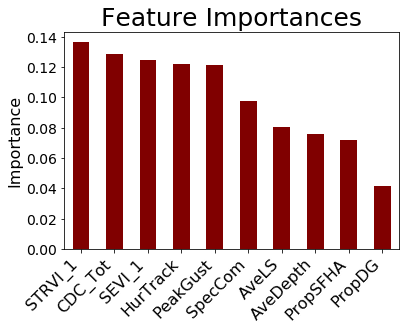

In [48]:
# EXAMPLE
gini_importance_plot(df_gini_importances)

## Permutation Importance Calculation

Permutation feature importance is a model inspection technique that can be used for any fitted estimator when the data is rectangular. This is especially useful for non-linear or opaque estimators. The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled 1. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature. This technique benefits from being model agnostic and can be calculated many times with different permutations of the feature.

The permutation_importance function calculates the feature importance of estimators for a given dataset. The n_repeats parameter sets the number of times a feature is randomly shuffled and returns a sample of feature importances. Permutation importances can either be computed on the training set or an held-out testing or validation set. Using a held-out set makes it possible to highlight which features contribute the most to the generalization power of the inspected model. Features that are important on the training set but not on the held-out set might cause the model to overfit.

In [49]:
# def permutation_importances(model, x_train, y_train, metric):
#     baseline = metric(model, x_train, y_train)
#     imp = []
#     for col in x_train.columns:
#         save = x_train[col].copy()
#         x_train[col] = np.random.permutation(x_train[col])
#         m = metric(model, x_train, y_train)
#         x_train[col] = save
#         imp.append(baseline - m)
#     return np.array(imp)
    

In [103]:
imp = permutation_importances(OPT3, x_train, y_train, oob_regression_r2_score)

In [104]:
impcopy = imp.copy()

In [105]:
def perm_imp_plot(importances):
    importances.reset_index(inplace=True)
    importances.sort_values('Importance', ascending=False).plot.bar('Feature',
                                                                            'Importance', 
                                                                            color='maroon', 
                                                                            legend = False)
    plt.title("Feature Importances", fontsize = 25)
    plt.ylabel('Importance', fontsize = 16)
    plt.xlabel('')
    plt.xticks(fontsize = 16, rotation = 45, ha='right')
    plt.yticks(fontsize = 14)
#     plt.savefig('giniimportance.png', dpi=600, bbox_inches = "tight")
    



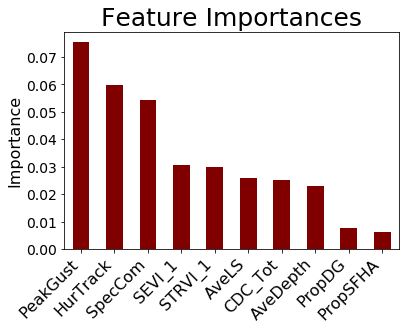

In [106]:
perm_imp_plot(imp)

In [59]:
imp

,Feature,Importance
0,HurTrack,0.105233
1,PeakGust,0.078472
2,STRVI_1,0.050754
3,CDC_Tot,0.038967
4,AveLS,0.029847
5,SpecCom,0.029393
6,AveDepth,0.029041
7,SEVI_1,0.018714
8,PropSFHA,0.011211
9,PropDG,0.005058


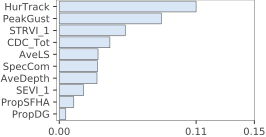

In [60]:
viz = plot_importances(impcopy)
viz

### Importances with test set

In [61]:
imp2 = permutation_importances(OPT3, x_test, y_test, oob_regression_r2_score)
imp2copy = imp2.copy()

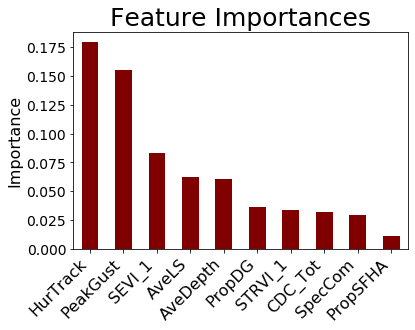

In [62]:
perm_imp_plot(imp2)

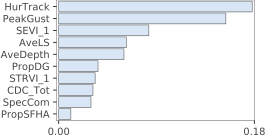

In [63]:
viz = plot_importances(imp2copy)
viz

## Group Permutation Importance

In [64]:
x_train.columns

Index(['PropSFHA', 'AveDepth', 'PropDG', 'AveLS', 'HurTrack', 'PeakGust',
       'SpecCom', 'STRVI_1', 'SEVI_1', 'CDC_Tot'],
      dtype='object')

In [65]:
features = [['PeakGust', 'HurTrack'],
           ['STRVI_1', 'SpecCom', 'SEVI_1', 'CDC_Tot'],
           ['AveDepth', 'AveDepth', 'PropDG', 'PropSFHA'],
           ['AveLS']]


In [66]:
I = importances(OPT3, x_train, y_train, features = features)
Icopy = I.copy()

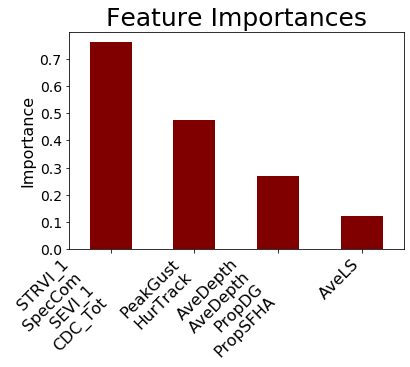

In [67]:
perm_imp_plot(I)

In [68]:
I

,Feature,Importance
0,STRVI_1\nSpecCom\nSEVI_1\nCDC_Tot,0.760974
1,PeakGust\nHurTrack,0.475786
2,AveDepth\nAveDepth\nPropDG\nPropSFHA,0.267032
3,AveLS,0.123490


In [69]:
I.drop(['Feature'], axis=1)
I['Feature'] = ['Vulnerability', 'Wind', 'Flood', 'Landslide']

In [70]:
I

,Feature,Importance
0,Vulnerability,0.760974
1,Wind,0.475786
2,Flood,0.267032
3,Landslide,0.123490


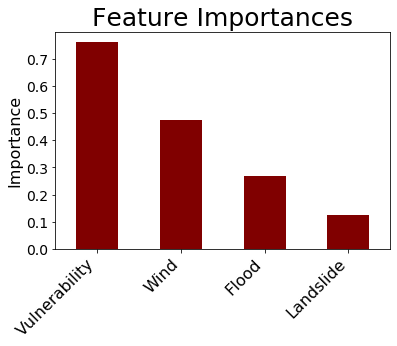

In [71]:
perm_imp_plot(I)

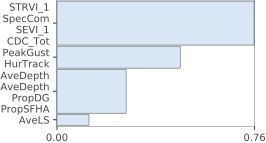

In [72]:
plot_importances(Icopy)

### Group importances with test set

In [73]:
I2 = importances(OPT3, x_test, y_test, features = features)
I2copy = I2.copy()

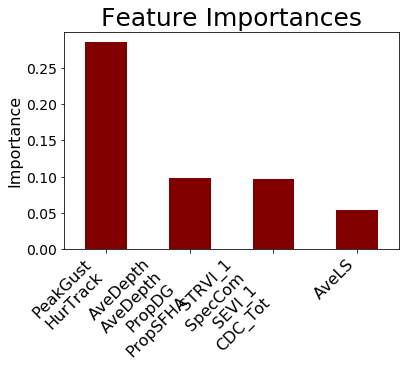

In [74]:
perm_imp_plot(I2)

In [75]:
I2

,Feature,Importance
0,PeakGust\nHurTrack,0.285686
1,AveDepth\nAveDepth\nPropDG\nPropSFHA,0.098001
2,STRVI_1\nSpecCom\nSEVI_1\nCDC_Tot,0.096255
3,AveLS,0.054182


In [76]:
I2.drop(['Feature'], axis=1)
I2['Feature'] = ['Wind', 'Vulnerability','Flood', 'Landslide']

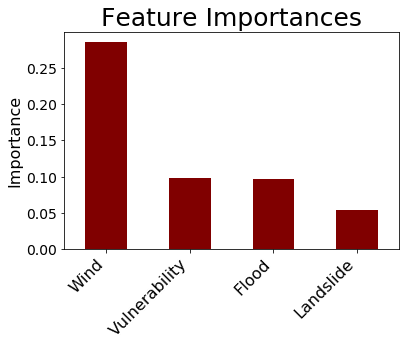

In [77]:
perm_imp_plot(I2)

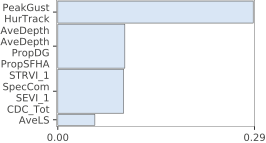

In [78]:
plot_importances(I2copy)

## Partial Dependencies

In [79]:
def plot_part_depend(model, x_train, feature_list, feature_names):
    with plt.rc_context({'legend.fontsize': 'large',
              'figure.figsize': (20, 40),
             'axes.labelsize': 'large',
             'axes.titlesize':'x-large',
             'xtick.labelsize':'large',
             'ytick.labelsize':'large'}):
        #plt.subplots(nrows=3,ncols=3, sharey=True)
        plot_partial_dependence(model, 
                                x_train, 
                                feature_list, 
                                feature_names = feature_names, 
                                grid_resolution=10, 
                                n_cols=2,
                                method='brute'
                               ) 
        #plt.savefig('partialdependence.png', dpi=400, bbox_inches = "tight")

In [82]:
x_train.head()

,PropSFHA,AveDepth,PropDG,AveLS,HurTrack,PeakGust,SpecCom,STRVI_1,SEVI_1,CDC_Tot
FIPS,,,,,,,,,,
72127005401,0.00,0.00,0.00,0.80,0.26,61.24,0.029121,-3.11,8.16,0.4632
72127009903,0.00,0.00,0.00,1.60,0.20,60.35,0.667688,-3.98,7.79,0.1019
72033020422,0.27,0.00,0.00,1.00,0.24,61.24,1.278594,2.79,-8.06,0.9388
72127010042,0.00,0.69,0.01,1.25,0.20,60.35,0.055834,6.51,9.00,0.1665
72054580100,0.00,0.00,0.00,0.53,0.00,50.52,0.014294,2.81,1.00,0.5266


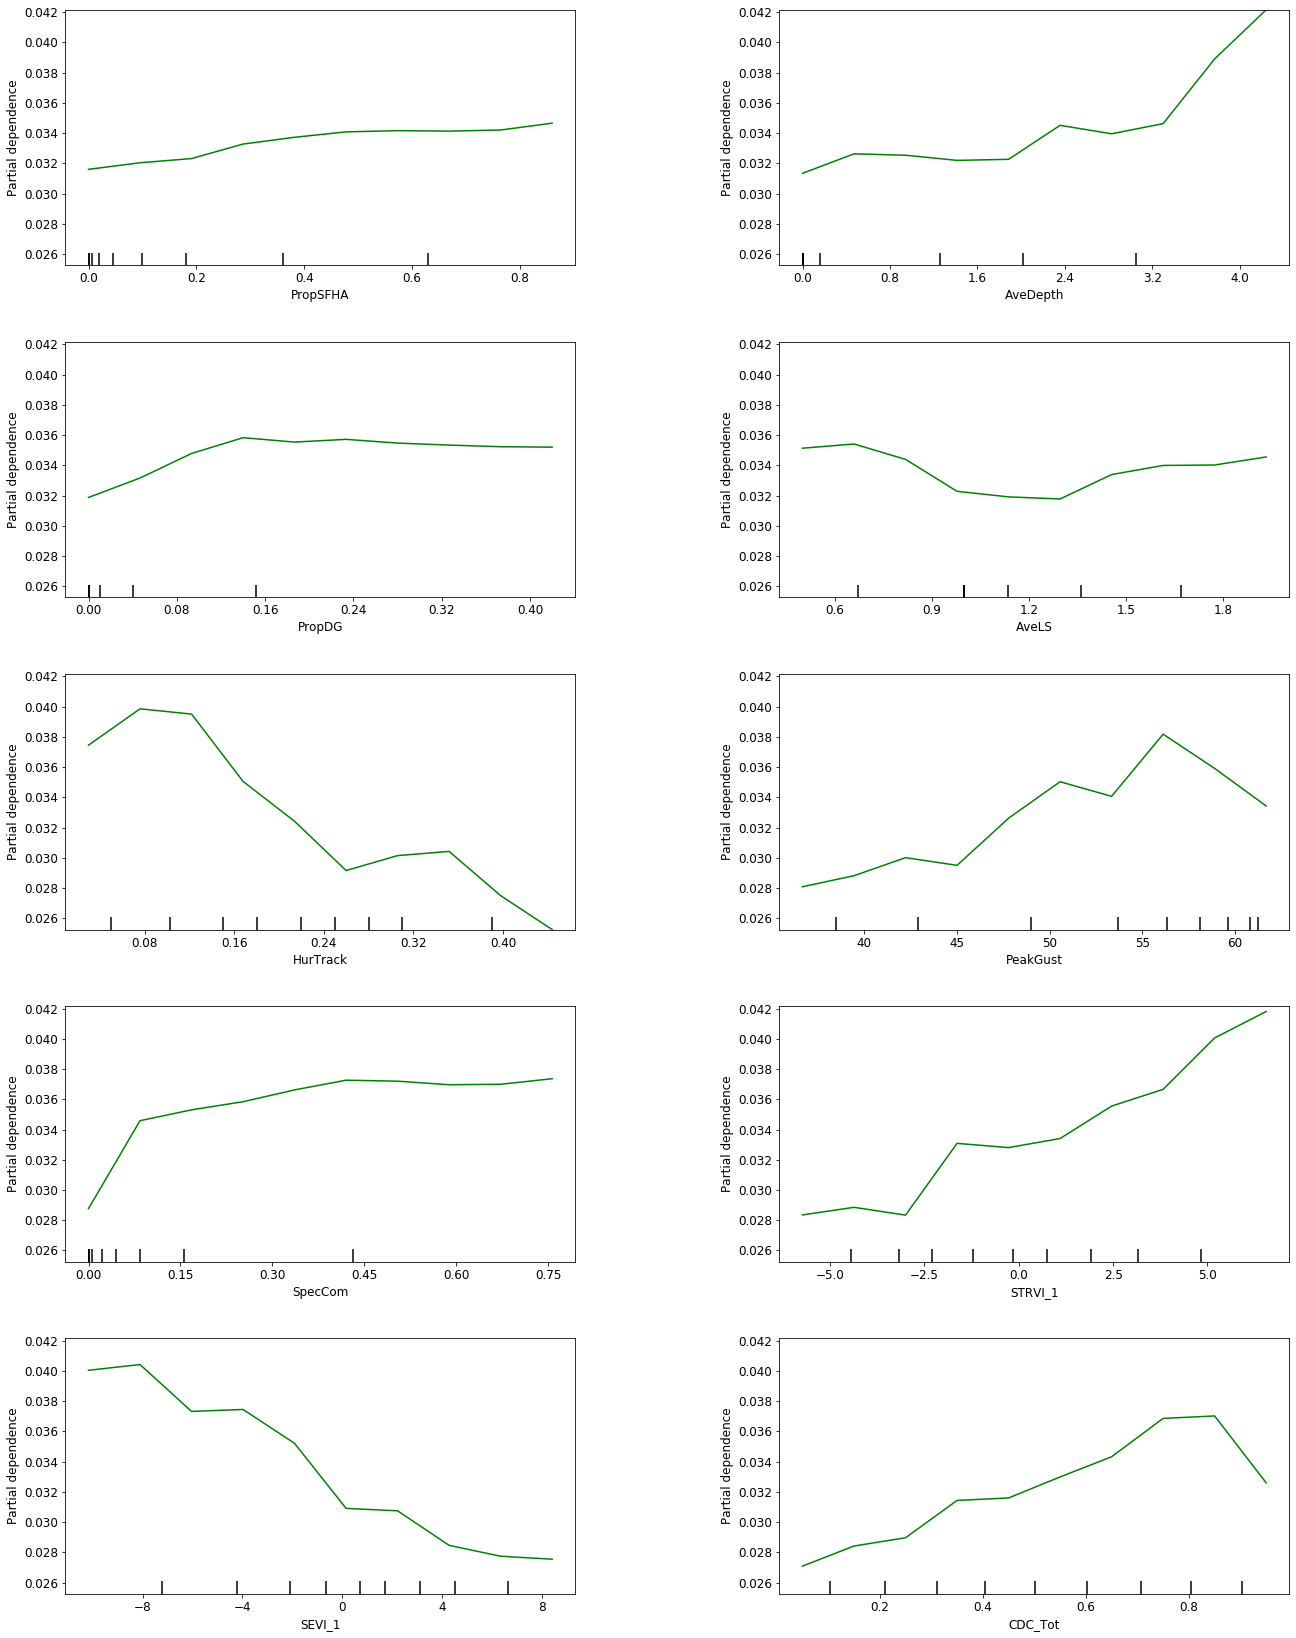

In [83]:
#EXAMPLE
feature_list=[0,1,2,3,4,5,6,7,8,9]
feature_names=['PropSFHA', 'AveDepth', 'PropDG', 'AveLS', 'HurTrack',
       'PeakGust', 'SpecCom', 'STRVI_1', 'SEVI_1', 'CDC_Tot']
plot_part_depend(OPT3, x_train, feature_list, feature_names)

In [87]:
def partial_dependence(x_train, model, variable1, variable2, xlabel, ylabel):
    with plt.rc_context({'legend.fontsize': 'large',
              'figure.figsize': (6, 6),
             'axes.labelsize': 'large',
             'axes.titlesize':'x-large',
             'xtick.labelsize':'large',
             'ytick.labelsize':'large'}):
        forty_ice_df = ice(data=x_train, column=variable1, 
                       predict=model.predict)
        cmap2 = plt.get_cmap('OrRd')
        wt_vals = forty_ice_df.columns.get_level_values(variable2).values
        sm = plt.cm.ScalarMappable(cmap=cmap2, 
                                   norm=plt.Normalize(vmin=wt_vals.min(), 
                                                      vmax=wt_vals.max()))
        sm._A = []
        ice_plot(forty_ice_df, linewidth=.5, color_by=variable2, cmap=cmap2, plot_pdp=True, 
                 pdp_kwargs={'c': 'k', 'linewidth': 5})
        plt.colorbar(sm, label=variable2)
        plt.ylabel(ylabel)
        plt.xlabel(xlabel);

In [88]:
x_train.columns

Index(['PropSFHA', 'AveDepth', 'PropDG', 'AveLS', 'HurTrack', 'PeakGust',
       'SpecCom', 'STRVI_1', 'SEVI_1', 'CDC_Tot'],
      dtype='object')

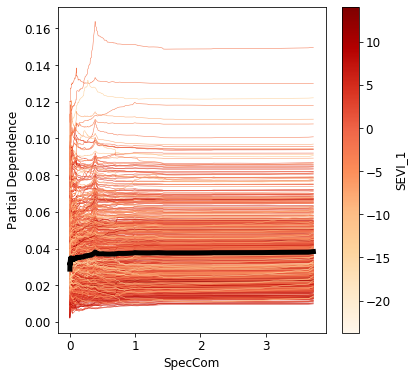

In [100]:
#EXAMPLE
model=OPT3
variable1='SpecCom'
variable2='SEVI_1'
xlabel='SpecCom' 
ylabel= 'Partial Dependence'
partial_dependence(x_train, model, variable1, variable2, xlabel, ylabel)

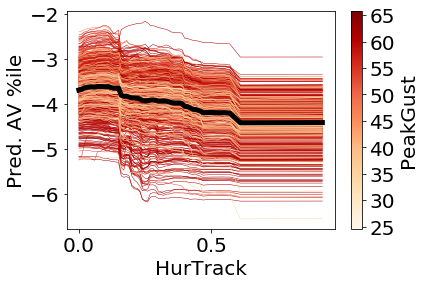

In [368]:
forty_ice_df = ice(data=x_train, column='HurTrack', 
                   predict=OPT4.predict)
cmap2 = plt.get_cmap('OrRd')
wt_vals = forty_ice_df.columns.get_level_values('PeakGust').values
sm = plt.cm.ScalarMappable(cmap=cmap2, 
                           norm=plt.Normalize(vmin=wt_vals.min(), 
                                              vmax=wt_vals.max()))
sm._A = []
ice_plot(forty_ice_df, linewidth=.5, color_by='PeakGust', cmap=cmap2, plot_pdp=True, 
         pdp_kwargs={'c': 'k', 'linewidth': 5})
plt.colorbar(sm, label='PeakGust')
plt.ylabel('Pred. AV %ile')
plt.xlabel('HurTrack');

## Spearman's correlation matrix

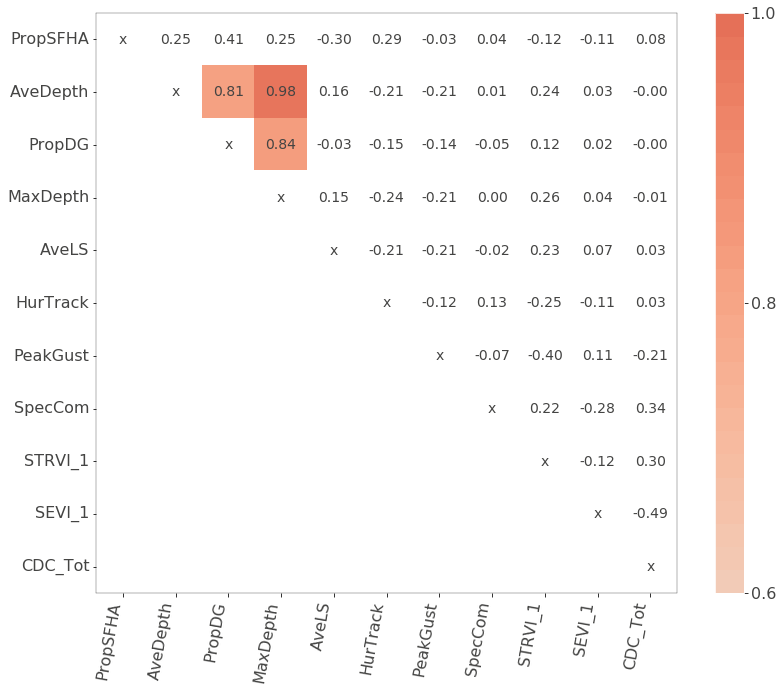

In [143]:
viz = plot_corr_heatmap(x_train, figsize=(14,10), label_fontsize=16, value_fontsize=14)
viz.view()


### Standard Classification Model

In [253]:
def run_classification(x_train, y_train,):
    class_model = RandomForestClassifier(random_state=42)
    class_model.fit(x_train, y_train)
    return class_model

In [31]:
# EXAMPLE
# Careful of Random State
class_model = run_classification(x_train, y_train)

### Evaluate Classification

In [36]:
def evaluate_classification(model, x_train, x_test, y_train, y_test):
    pred = model.predict(x_test)
    accuracy_train = model.score(x_train, y_train)
    print('The mean training accuracy is {}'.format(accuracy_train))
    accuracy_test = model.score(x_test, y_test)
    print('The mean test accuracy is {}'.format(accuracy_test))
    df_confusion = pd.DataFrame(confusion_matrix(y_test, pred))
    print(df_confusion)
    print(classification_report(y_test, pred))
    return df_confusion

In [39]:
# EXAMPLE
# CHOOSE MODEL IF WANT TUNED OR JUST CLASSIFICATION WITH DEFAULT
df_confusion = evaluate_classification(hypertune_model, x_train, x_test, y_train, y_test)

In [76]:
def plot_confusion(df_confusion):
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_confusion, cmap='PuBu', annot=True, annot_kws={"size": 16})# font size
    plt.ylabel('Predicted')
    plt.xlabel('True Value')
#     plt.savefig('classification.png', dpi=600, bbox_inches = "tight")
    plt.show()

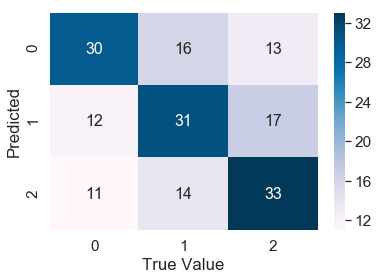

In [113]:
# EXAMPLE
plot_confusion(df_confusion)

In [38]:
# def calc_permutation_importance(criterion, model, df_x, y):
#     features = df_x.columns.values
#     X = df_x.as_matrix()
#     Y = y.as_matrix()
#     scores = defaultdict(list)
#     rf = model
#     for train_idx, test_idx in ShuffleSplit(len(X), 100, .3, random_state=42): #number of splits, absolute number of test samples, proportion of data in train split
#         X_train, X_test = X[train_idx], X[test_idx] #Random permutation cross-validator, Yields indices to split data into training and test sets.
#         Y_train, Y_test = Y[train_idx], Y[test_idx]
#         r = rf.fit(X_train, Y_train)
#         acc = criterion(Y_test, rf.predict(X_test))
#         for i in range(X.shape[1]): #The shape attribute for numpy arrays returns the dimensions of the array. If Y has n rows and m columns, then Y.shape is (n,m). So Y.shape[0] is n.
#             X_t = X_test.copy()
#             np.random.seed(42)
#             np.random.shuffle(X_t[:, i]) #rearranging randomly
#             shuff_acc = criterion(Y_test, rf.predict(X_t)) 
#             scores[features[i]].append((acc-shuff_acc)/acc) #change in importance, actual - shuffled/actual, this is percent error        
#     mda_features = [f for f in scores.keys()]
#     mda_importance = [(np.mean(score)) for score in scores.values()] #average over all the shuffled permutations
#     mda_indices = np.argsort(mda_importance)
#     return mda_features, mda_importance, mda_indices

In [73]:
# #EXAMPLE
# #criterion can be r2_score or mean_squared_error
# #should be mean_squared_error i think

# criterion = mean_squared_error
# mda_features, mda_importance, mda_indices = calc_permutation_importance(criterion, hypertune_model, df_x, y)

## Permutation Plot

In [184]:
def permutation_importance_plot(mda_features, mda_importance):
    df_perm_FI = pd.DataFrame({'Feature':mda_features, 'Importance':[abs(number) for number in mda_importance]})
    df_perm_FI.sort_values('Importance', ascending=False).plot.bar('Feature',
                                                                   'Importance', 
                                                                    color='maroon', 
                                                                    legend = False)
    plt.title("Feature Importances", fontsize = 30)
    plt.ylabel('Importance')
    plt.xlabel('')
    plt.xticks(fontsize = 12, rotation = 45, ha='right')
    plt.savefig('permutimportance.png', dpi=600, bbox_inches = "tight")

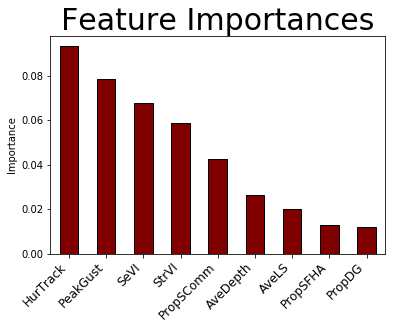

In [185]:
# EXAMPLE
permutation_importance_plot(mda_features, mda_importance)

## Export

In [170]:
train_set = x_train.copy()
test_set = x_test.copy()

In [171]:
train_set['y_train'] = y_train
train_set['train_pred'] = pred_train

test_set['y_test'] = y_test
test_set['test_pred'] = pred_test

In [173]:
train_set.to_excel("/Users/lszczyrba/Documents/Research/Projects/PR_Housing/Data/train_set_20191031.xlsx")
test_set.to_excel("/Users/lszczyrba/Documents/Research/Projects/PR_Housing/Data/test_set_20191031.xlsx")

In [ ]:
train_set = x_train.copy()
test_set = x_test.copy()

train_set['y_train'] = y_train
train_set['train_pred'] = pred_train

test_set['y_test'] = y_test
test_set['test_pred'] = pred_test

train_set.to_excel("/Users/lszczyrba/Documents/Research/Projects/PR_Housing/Data/train_set_20191209.xlsx")
test_set.to_excel("/Users/lszczyrba/Documents/Research/Projects/PR_Housing/Data/test_set_20191209.xlsx")

### Tree Visualization

In [27]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = reg_model.estimators_[5]
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

feature_list = list(df_x.columns)


# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
#Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')